In [5]:
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Pardiso
using PyPlot

In [ ]:
# Structure to represent overset grids, comprised of overlapping grids.
mutable struct SphericalSurfaceGrid
    # r, theta, phi
    # theta is the polar angle. phi is the longitude
    # latitude and longitude are defined in a local coordinate system for each grid
    
    ntheta::Int64
    nphi::Int64
    theta::Vector{Float64}
    phi::Vector{Float64}
    dtheta::Float64
    dphi::Float64
    r::Float64 # radius
    center::Vector{Float64}
    rotation::Float64
    yang::Bool

    function SphericalSurfaceGrid(ntheta,nphi,center,rotation,yang)
        # center defines the center of this grid
        # pad each of the grids by one cell in each direction.
        dtheta = pi/2 / (ntheta-1)
        dphi = 3*pi/2 / (nphi-1)
        thetas = LinRange(pi/4-dtheta,3*pi/4+dtheta,ntheta+2)
        phis = LinRange(-3*pi/4-dphi,3*pi/4+dphi,nphi+2)
        new(ntheta+2,nphi+2,thetas,phis,thetas[2]-thetas[1],phis[2]-phis[1],1.0,center,rotation,yang)
    end
end

mutable struct YinYangGrids
    grids::Vector{SphericalSurfaceGrid}
    function YinYangGrids(ntheta,nphi)
       grid1 = SphericalSurfaceGrid(ntheta,nphi,[0.,0.],0.0,false)
       grid2 = SphericalSurfaceGrid(ntheta,nphi,[pi/2,pi],pi/2,true)
    new([grid1,grid2])
    end
end

# degrees of freedom will be laid out starting with the first grid and proceeding through the grids.
@inline node(i,j,grid::Int64,grids::YinYangGrids) = (grid-1)*grids.grids[1].ntheta*grids.grids[1].nphi + (j-1)*grids.grids[grid].ntheta + i

function sph2cart(r::Float64,theta::Float64,phi::Float64)
    x = r*sin(theta)*cos(phi)
    y = r*sin(theta)*sin(phi)
    z = r*cos(theta)
    return x,y,z
end

function cart2sph(x::Float64,y::Float64,z::Float64)
   r = (x^2+y^2+z^2)^0.5
   theta = acos(z/r)
   phi   = atan(y,x)
   return r,theta,phi
end

function grid2xyz(grid::SphericalSurfaceGrid)
    x = zeros(grid.ntheta,grid.nphi)
    y = zeros(grid.ntheta,grid.nphi)
    z = zeros(grid.ntheta,grid.nphi)
    for i in 1:grid.ntheta
        for j in 1:grid.nphi
            xt,yt,zt = sph2cart(grid.r,grid.theta[i],grid.phi[j])
            x[i,j] = xt
            y[i,j] = yt
            z[i,j] = zt
        end
    end
    if grid.yang
        return -x,z,y
    else
        return  x,y,z
    end
end

# code to write a .vtr file:
function visualization(grid::SphericalSurfaceGrid, f::Array{Float64} ; filename="test.vts")
    # write the visualization output from the regular grid as a .vts file.
    x,y,z = grid2xyz(grid)
    x=reshape(x,grid.ntheta,grid.nphi,1)
    y=reshape(y,grid.ntheta,grid.nphi,1)
    z=reshape(z,grid.ntheta,grid.nphi,1)
    f=reshape(f,grid.ntheta,grid.nphi,1)
    vtk_grid(filename, x, y, z) do vtk
        vtk["phi"] = f
    end
end

# define one grid to be the main grid
# in the overlapping regions, other grids will have values at overlapping coordinates prescribed.
# let r=1, 

# compute the overlaps. assemble a matrix whose rows correspond to 
# degree of freedom on grid 2, columns correspond to weights that interpolate quantities from grid 1.

# (on grid 2):
# loop over points
n=100
grids = YinYangGrids(n + 1,3*n+1)
grid2 = grids.grids[2]
grid1 = grids.grids[1]
yang_xyz = grid2xyz(grids.grids[2])

enclosed = Matrix{Float64}(undef,grid2.ntheta,grid2.nphi)
match = Matrix{Bool}(undef,grid2.ntheta,grid2.nphi)
for i in 1:grid2.ntheta
    for j in 1:grid2.nphi
        x,y,z = sph2cart(grid2.r,grid2.theta[i],grid2.phi[j])
        r,t,p = cart2sph(-x,z,y)
        if t > grid1.theta[1] && t < grid1.theta[end] && p > grid1.phi[1] && p < grid1.phi[end]
            enclosed[i,j] = true
            match[i,j] = any(isapprox.(t,grid1.theta)) && any(isapprox.(p,grid1.phi))
        else
            enclosed[i,j] = false
            match[i,j] = false
        end        
    end
end

# grid2 -> grid1 (x,y,z) -> (-x,z,y)
# grid1 -> grid2 (x,y,z) -> (-x,z,y) (clever...)
function compute_constraints(grids::YinYangGrids)
    #    transform point to grid 1 coordinates
    #    compute whether this point is enclosed within grid 1.
    #    no -> do nothing
    #    yes -> there will be an entry in the matrix.

    grid1 = grids.grids[1]
    grid2 = grids.grids[2]
    
    nn = 5*2*(2*grid1.ntheta + 2*grid1.nphi);
    row = Vector{Int64}(undef,nn)
    col = Vector{Int64}(undef,nn)
    val = Vector{Float64}(undef,nn)
    
    k=1;
    for cycle = 1:2
        local grid1
        local grid2
        if cycle == 1
            grid1 = grids.grids[1]
            grid2 = grids.grids[2]
            this = 1
            other = 2
        else
            grid1 = grids.grids[2]
            grid2 = grids.grids[1]
            this = 2
            other = 1
        end
        for i in 1:grid2.ntheta 
            for j in 1:grid2.nphi # left/right columns
                if i == 1 || i == grid2.ntheta || j == 1 || j == grid2.nphi
                    x,y,z = sph2cart(grid2.r,grid2.theta[i],grid2.phi[j])
                    r,t,p = cart2sph(-x,z,y)
                    t_cell = Int64( floor( (t-grid1.theta[1])/grid1.dtheta )+1 )
#                     t_call = t_cell > grid1.ntheta-1 ? grid1.ntheta-1 : grid1.ntheta-1
                    p_cell = Int64( floor( (p-grid1.phi[1])/grid1.dphi )+1 )
#                     p_call = p_cell > grid1.nphi-1 ? grid1.nphi-1 : grid1.nphi-1
                    if t_cell == 1 || t_cell == grid1.ntheta-1
                        print("nooo!")
                    end
                    if p_cell == 1 || p_cell == grid1.nphi-1
                        print("nooo!")
                    end
                    
                    w_t = (t-grid1.theta[t_cell])/grid1.dtheta
                    w_p = (p-grid1.phi[p_cell])/grid1.dphi
                    # constrain the value at node i,j on the other grid...
                    this_row = node(i,j,other,grids)
                    row[k] = this_row
                    col[k] = this_row
                    val[k] = 1.0/grid1.dtheta^2
                    k+=1;            
                    # ... to be the interpolated value from the four neighbors on this grid.
                    row[k] = this_row
                    col[k] = node(t_cell,p_cell,this,grids)
                    val[k] = -(1.0-w_t)*(1.0-w_p)/grid1.dtheta^2
                    k+=1;
                    row[k] = this_row
                    col[k] = node(t_cell+1,p_cell,this,grids)
                    val[k] = -(w_t)*(1.0-w_p)/grid1.dtheta^2
                    k+=1;
                    row[k] = this_row
                    col[k] = node(t_cell,p_cell+1,this,grids)
                    val[k] = -(1.0-w_t)*(w_p)/grid1.dtheta^2
                    k+=1;
                    row[k] = this_row
                    col[k] = node(t_cell+1,p_cell+1,this,grids)
                    val[k] = -(w_t)*(w_p)/grid1.dtheta^2
                    k+=1; 
                end
            end
        end
    end

    row = row[1:k-1]
    col = col[1:k-1]
    val = val[1:k-1]
    return row,col,val
end

rowc,colc,valc = compute_constraints(grids)
figure()
scatter(rowc,colc,s=0.1)

In [ ]:
x,y,z = grid2xyz(grids.grids[1])

dof1 = [node(i,j,1,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[1].nphi]
dof2 = [node(i,j,2,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[2].nphi]

using PyPlot

fig = figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(x,y,z,c=dof1,s=0.1,cmap=get_cmap("jet"))
ax.scatter(-x,z,y,c=dof2,s=0.1,cmap=get_cmap("jet"))

fig.show()

In [ ]:
enclosed
print(size(enclosed))
print(size(grid2.phi))


In [ ]:
figure()
pcolormesh(grid2.phi, grid2.theta, enclosed)
colorbar()
figure()
pcolormesh(match)
 colorbar()

In [ ]:
test = [sph2cart(1.0,t,p) for t in grid1.theta, p in grid1.phi]


In [ ]:
[cart2sph(a[1],a[2],a[3]) for a in test]

In [ ]:
[(1.0,t,p) for t in grid1.theta, p in grid1.phi]

In [ ]:
dof1

In [ ]:
dof2

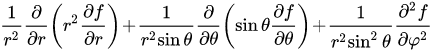

In [ ]:
# discretize the poisson equation on grid1.
grid1 = grids.grids[1]
N = grid1.ntheta*grid1.nphi*2
row = Vector{Int64}(undef,5*N)
col = Vector{Int64}(undef,5*N)
val = Vector{Float64}(undef,5*N)
R = Vector{Float64}(undef,N)
k = 1
for igrid in 1:2
    local grid = grids.grids[igrid]
    gx,gy,gz = grid2xyz(grid)
    
    for j in 1:grid.nphi
        for i in 1:grid.ntheta
            this_row::Int64 = node(i,j,igrid,grids)
            if (i==1 || i == grid.ntheta || j == 1 || j == grid.nphi)
                # constraint equation
                R[this_row] = 0.0
            else
                # center
                theta_cp = 0.5*(grid.theta[i+1]+grid.theta[i])
                theta_cm = 0.5*(grid.theta[i]  +grid.theta[i-1])
                row[k] = this_row
                col[k] = this_row
                val[k] = -1.0/grid.r^2 * sin(theta_cp)/sin(grid.theta[i])/grid.dtheta^2 +
                    -1.0/grid.r^2*sin(theta_cm)/sin(grid.theta[i])/grid.dtheta^2 +
                    -1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2 +
                    -1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2;
                k+=1
                # +theta
                row[k] = this_row
                col[k] = node(i+1,j,igrid,grids)
                val[k] = 1.0/grid.r^2 * sin(theta_cp)/sin(grid.theta[i])/grid.dtheta^2
                k+=1
                # -theta
                row[k] = this_row
                col[k] = node(i-1,j,igrid,grids)
                val[k] = 1.0/grid.r^2 * sin(theta_cm)/sin(grid.theta[i])/grid.dtheta^2
                k+=1
                # +phi
                row[k] = this_row
                col[k] = node(i,j+1,igrid,grids)
                val[k] = 1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2
                k+=1
                # -phi
                row[k] = this_row
                col[k] = node(i,j-1,igrid,grids)
                val[k] = 1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2
                k+=1
                r,t,p = cart2sph(gx[i,j],gy[i,j],gz[i,j])
#                 R[this_row] = cos(t)^2/sin(t)*cos(p) - sin(t)*cos(p) - cos(p)/sin(t)
                R[this_row] = cos(t)
#                 R[this_row] = (igrid == 1 && abs( pi/2-grid.theta[i] ) < pi/8 && abs(grid.phi[j]) < pi/8) ? 1.0 : 0.0
            end
        end
    end
end
row = cat(row[1:k-1] ,rowc ; dims=1)
col = cat(col[1:k-1] ,colc ; dims=1)
val = cat(val[1:k-1] ,valc ; dims=1)
L = sparse(row,col,val);

#  L[node(2,2,1,grids),:] .= 0;
#  L[node(2,2,1,grids),node(2,2,1,grids)] = 1.0
#  R[node(2,2,1,grids)] = 0.0

solution = L\R
# solution = gmres(L,R)

In [ ]:
node(1,1,1,grids)
mask = row .== node(1,1,1,grids)
col[mask]

In [ ]:
L[node(2,2,1,grids),:]

In [ ]:
any(isinf.(R))

In [ ]:
figure()
N = grids.grids[1].ntheta * grids.grids[1].nphi
pcolor(reshape(R[1:N],grids.grids[1].ntheta,grids.grids[1].nphi))
colorbar()

In [ ]:
maximum(L)

In [ ]:
dof1 = [node(i,j,1,grids) for j in 1:grids.grids[1].nphi, i in 1:grids.grids[1].ntheta]
dof2 = [node(i,j,2,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[2].nphi]

using PyPlot

fig = figure()
ax = fig.add_subplot(projection="3d")
x,y,z = grid2xyz(grids.grids[1])

N = grids.grids[1].ntheta * grids.grids[1].nphi
vmin = minimum(solution)
vmax = maximum(solution)
ax.scatter(x,y,z,c=reshape(solution[1:N],grids.grids[1].ntheta,grids.grids[1].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)


fig = figure()
ax = fig.add_subplot(projection="3d")
x,y,z = grid2xyz(grids.grids[2])
ax.scatter(x,y,z,c=reshape(solution[N+1:end],grids.grids[2].ntheta,grids.grids[2].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)


fig = figure()
ax = fig.add_subplot(projection="3d")
x,y,z = grid2xyz(grids.grids[1])
ax.scatter(x,y,z,c=reshape(solution[1:N],grids.grids[1].ntheta,grids.grids[1].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)
x,y,z = grid2xyz(grids.grids[2])
ax.scatter(x,y,z,c=reshape(solution[N+1:end],grids.grids[2].ntheta,grids.grids[2].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)

fig.show()

In [ ]:
# write VTK files with yin and yang components of the solution...

visualization(grids.grids[1],solution[1:N],filename="yin.vts")
visualization(grids.grids[2],solution[N+1:end],filename="yang.vts")

In [ ]:
L[node(2,2,1,grids),:]